# Introduction

This notebook goes through local volume estimation for our 2D example in depth, complete with visualizations of the arrows to confirm they really match our intentions.

# Landscape and NN Class

In [1]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from typing import List

class LossLandscape:
    def __init__(self, 
                 minima_sharp_loc=-1.0, 
                 minima_wide_loc=1.0,
                 sharp_width=0.1,
                 wide_width=0.2,
                 amplitude=1.0,
                 baseline=1.0):
        """
        Initialize a customizable loss landscape with two minima.
        """
        self.minima_sharp_loc = minima_sharp_loc
        self.minima_wide_loc = minima_wide_loc
        self.sharp_width = sharp_width
        self.wide_width = wide_width
        self.amplitude = amplitude
        self.baseline = baseline
        
    def get_minima_parameters(self):
        """Return the key parameters defining the minima"""
        return {
            'minima_sharp_loc': self.minima_sharp_loc,
            'minima_wide_loc': self.minima_wide_loc,
            'sharp_width': self.sharp_width,
            'wide_width': self.wide_width
        }
        
    def __call__(self, x):
        """Compute the loss at point(s) x"""
        gaussian_sharp = self.amplitude * torch.exp(
            -0.5 * ((x - self.minima_sharp_loc) / self.sharp_width)**2
        )
        gaussian_wide = self.amplitude * torch.exp(
            -0.5 * ((x - self.minima_wide_loc) / self.wide_width)**2
        )
        return self.baseline - gaussian_sharp - gaussian_wide
    
    def visualize(self, x_range=(-2, 2), num_points=500):
        """Visualize the loss landscape"""
        x = torch.linspace(x_range[0], x_range[1], num_points)
        loss = self(x)
        
        plt.figure(figsize=(8, 5))
        plt.plot(x.numpy(), loss.numpy())
        plt.xlabel('x')
        plt.ylabel('Loss')
        plt.title('Loss Landscape')
        
        plt.axvline(x=self.minima_sharp_loc, color='r', 
                   linestyle='--', alpha=0.3, label='Sharp minimum')
        plt.axvline(x=self.minima_wide_loc, color='b', 
                   linestyle='--', alpha=0.3, label='Wide minimum')
        
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()

    def random_parameter_search(self, dim: int, num_samples: int = 10000, upper = 10, low = -10):
        """
        Perform random parameter search using the class's minima parameters
        
        Args:
            dim: Dimension of parameter space
            num_samples: Number of random samples to generate
            
        Returns:
            Tuple of (sharp_count, wide_count, samples)
        """
        minima_sharp_count = 0
        minima_wide_count = 0
        samples = []
        
        for _ in range(num_samples):
            params = np.random.uniform(low=low, high=upper, size=dim)
            product = np.prod(params)
            samples.append(product)
            
            if abs(product - self.minima_sharp_loc) < self.sharp_width:
                minima_sharp_count += 1
            if abs(product - self.minima_wide_loc) < self.wide_width:
                minima_wide_count += 1
        
        return minima_sharp_count, minima_wide_count, samples
        
class NParameterModel(torch.nn.Module):
    def __init__(self, initial_values: List[float]):
        super().__init__()
        # Create N parameters from the initial values
        self.params = torch.nn.ParameterList([
            torch.nn.Parameter(torch.tensor([val], dtype=torch.float32))
            for val in initial_values
        ])
    
    def forward(self):
        # Compute product of all parameters
        x = torch.prod(torch.stack([p for p in self.params]))
        return x

    def get_parameter_values(self):
        return [p.item() for p in self.params]

# Model Perturber, Generate and Evaluate Wiggles

In [2]:
# from perturb_simple import (ModelPerturber, generate_random_perturbation, 
#                             normalize_perturbation_to_unit_norm, generate_random_perturbations, 
#                             wiggle_multiple_directions, wiggle_simple

# Class for implementing perturbations
class ModelPerturber:
    def __init__(self, model):
        self.model = model
        self.original_state = {n: p.detach().clone() 
                              for n, p in model.named_parameters()}
    
    def apply_perturbation(self, perturbation_dict):
        """
        Apply custom perturbations to model weights
        perturbation_dict: {param_name: tensor_with_same_shape}
        """
        with torch.no_grad():
            for name, param in self.model.named_parameters():
                if name in perturbation_dict:
                    param.add_(perturbation_dict[name])
    
    def reset(self):
        """Revert to original weights"""
        with torch.no_grad():
            for name, param in self.model.named_parameters():
                param.copy_(self.original_state[name])

def generate_random_perturbation(model, scale=1.0, seed=None):
    """
    Generate random perturbation direction for model parameters.
    Returns: Dictionary {param_name: perturbation_tensor}
    """
    if seed is not None:
        torch.manual_seed(seed)
    
    return {name: torch.randn_like(param) * scale for name, param in model.named_parameters()}
    
def normalize_perturbation_to_unit_norm(perturbations):
    """
    Normalize the entire perturbation to have total L2 norm = 1 across all parameters
    Returns: Dictionary {param_name: normalized_perturbation_tensor} with ||perturbation||₂ = 1
    """
    # Flatten all perturbations into a single vector
    all_perturbs = torch.cat([p.flatten() for p in perturbations.values()])
    total_norm = torch.norm(all_perturbs, p=2)
    # Normalize if norm > 0
    if total_norm > 1e-10:  # Small threshold to avoid division by zero
        scale = 1.0 / total_norm
    else:
        scale = 1.0  # If perturbation is ~0, leave unchanged
    # Apply scaling to each parameter's perturbation
    normalized_perturbs = {name: perturb * scale 
                         for name, perturb in perturbations.items()}
    
    return normalized_perturbs

def generate_random_perturbations(model, n):
    """Generate n random unit-norm perturbation directions."""
    perturbations = []
    for _ in range(n):
        raw_perturb = generate_random_perturbation(model)
        unit_perturb = normalize_perturbation_to_unit_norm(raw_perturb)
        perturbations.append(unit_perturb)
    return perturbations

def wiggle_simple(simple_model, loss_fn, perturbation_direction, coefficients):
    """
    Evaluates the model with given perturbation coefficients applied to each direction.
    
    Args:
        simple_model: A simple model that returns the parameter value directly.
        loss_fn: the loss for that parameter value
        perturbations: List of dictionaries [{param_name: tensor}] of what the specific perturbation does to each weight
        coefficients: List of coefficients to apply to each perturbation direction
        
    Returns:
        Dictionary containing:
        - 'losses': array of losses for each perturbation
        - 'coefficients': array of coefficients used (same as input)
        - 'perturbations': list of perturbation directions used
    """
    perturber = ModelPerturber(simple_model)
    losses = []

    for i, coeff in enumerate(coefficients):
        perturbation = {
            name: perturbation_direction[name] * coeff
            for name in perturbation_direction
        }

        perturber.apply_perturbation(perturbation)

        with torch.no_grad():
            x = simple_model()
            loss = loss_fn(x)
            losses.append(loss.item())
            
        perturber.reset()

    return {
        'losses': np.array(losses),
        'coefficients': coefficients,
        'perturbations': perturbation_direction,
    }

def wiggle_multiple_directions(
    model,
    loss_fn,
    perturbation_directions,  # List of {param_name: tensor} dicts
    coefficients,             # List of coefficients (same for all directions)
    verbose=False,            # Print progress
):
    """
    Evaluates wiggle_simple along a list of perturbations
    
    Returns:
        List of results (same format as wiggle_simple), one per direction.
    """
    results = []
    
    for i, direction in enumerate(perturbation_directions):
        if verbose:
            print(f"Evaluating direction {i+1}/{len(perturbation_directions)}...")
        
        # Run wiggle_simple for this direction
        result = wiggle_simple(
            simple_model=model,
            loss_fn=loss_fn,
            perturbation_direction=direction,
            coefficients=coefficients,
        )
        results.append(result)
    
    return results

# Estimate Volumes

In [3]:
# from perturb_simple import (loss_threshold_crossing, exp_r_n, evaluate_model_volumes

def loss_threshold_crossing(wiggle_results, loss_threshold):
    """
    Find the radius r at which each direction first crosses the loss threshold.
    
    Args:
        wiggle_results: List of result dicts containing 'losses' and 'coefficients'
        Access is in the form wiggle_results[list_index]['losses'][loss for specific coeff]
        loss_threshold: Loss value threshold to search for
    
    Returns:
        Tuple of (r_values, valid_directions) where:
        - r_values: List of radii where threshold was crossed (empty if never crossed)
        - valid_directions: Boolean mask indicating which directions crossed threshold
    """
    r_values = []
    valid_directions = []
    
    for result in wiggle_results:
        coefficients = result['coefficients']
        losses = result['losses']
        crossed = False
        
        # Find first point where loss exceeds threshold
        for i in range(len(losses)):
            if losses[i] > loss_threshold:
                if i > 0:  # Only record if we have a valid previous point
                    r_values.append(abs(coefficients[i-1]))
                    crossed = True
                break
                
        valid_directions.append(crossed)
    
    return r_values, valid_directions

def exp_r_n(wiggle_results, loss_threshold, n):
    """
    Compute expected r^n value across valid directions.
    
    Args:
        wiggle_results: List of result dicts containing 'losses' and 'coefficients'
        loss_threshold: Loss value threshold to search for
        n: Exponent for r^n calculation
    
    Returns:
        Tuple of (expected_rn, num_valid_directions) where:
        - expected_rn: Average of r^n across valid directions
        - num_valid_directions: Count of directions that crossed threshold
    """
    r_values, valid_directions = loss_threshold_crossing(wiggle_results, loss_threshold)
    if not r_values:
        return 0.0, 0
    # Compute r^n for each valid radius and average
    rn_values = [r**n for r in r_values]
    expected_rn = sum(rn_values) / len(rn_values)
    
    return expected_rn, sum(valid_directions)

def evaluate_model_volumes(trained_models, loss_fn, coefficients, loss_threshold, perturbation_number, n=1):
    """
    Evaluate volumes for all trained models and return results with classifications
    
    Args:
        trained_models: List of trained models with their metadata
        loss_fn: Loss landscape function
        coefficients: a list of coefficients to evaluate our model at, from 0 to some number
        loss_threshold: the loss threshold at which the perturbation should stop
        perturbation_number: number of perturbations to evaluate (random directions)
        n: Exponent for volume calculation, dimension of the problem.
        
    Returns:
        List of tuples (model, minima_type, volume_info) where volume_info is a dict containing:
            - 'volume': calculated volume
            - 'num_valid': number of valid directions
            - 'model_value': output of model()
    """
    volumes = []
    perturbation_directions = generate_random_perturbations(trained_models[0]['model'], perturbation_number)
    
    for model_data in trained_models:
        model = model_data['model']
        minima_type = model_data['minima_type']
        
        all_results = wiggle_multiple_directions(
            model=model,
            loss_fn=loss_fn,
            perturbation_directions=perturbation_directions,
            coefficients=coefficients,
            verbose=False
        )

        expected_r, num_valid = exp_r_n(all_results, loss_threshold, n)
        
        volumes.append((
            model,
            minima_type,
            {
                'volume': expected_r,
                'num_valid': num_valid,
            }
        ))
    
    return volumes

# Classifying Volumes

In [4]:
def classify_minima(x, 
                  minima_sharp_loc=-1.0, 
                  minima_wide_loc=1.0,
                  sharp_width=0.1,
                  wide_width=0.2):
    """
    Classify which minimum a given x value belongs to.
    
    Args:
        x: Final parameter value
        minima_sharp_loc: Location of sharp minimum
        minima_wide_loc: Location of wide minimum
        sharp_width: Width for sharp minimum classification
        wide_width: Width for wide minimum classification
        
    Returns:
        String classification ('sharp', 'wide', or 'none')
    """
    if abs(x - minima_sharp_loc) < sharp_width:
        return 'sharp'
    elif abs(x - minima_wide_loc) < wide_width:
        return 'wide'
    else:
        return 'none'

# In Depth Investigations

We want to understand in depth what our models are doing. Specifically, we want code that takes in a model (we specify the parameters), and computes the volume, visualizing the random projections it makes as well as the volume it estimates. We then want to apply this code to a variety of models, and see how the volume changes over time.

The first thing to do is specify the model. Then generate the list of coefficients to investigate, as well as the random perturbations.

In [5]:
# Initialize our loss landscape
minima_sharp_loc=-1.0, 
minima_wide_loc=1.0,
sharp_width=0.01,
wide_width=0.02
loss_fn = LossLandscape(minima_sharp_loc=-1.0, 
                 minima_wide_loc=1.0,
                 sharp_width=0.1,
                 wide_width=0.2)

model = NParameterModel([1, 1])

# Coefficients
N = 100
x = np.linspace(0, 1.5, N)
coefficients = x**3

loss_threshold = 0.5
perturbation_number = 5
perturbation_directions = generate_random_perturbations(model, perturbation_number)

In [6]:
for perturb in perturbation_directions:
    print (perturb)

{'params.0': tensor([-0.4967]), 'params.1': tensor([0.8679])}
{'params.0': tensor([-0.1986]), 'params.1': tensor([-0.9801])}
{'params.0': tensor([0.9479]), 'params.1': tensor([-0.3187])}
{'params.0': tensor([-0.4982]), 'params.1': tensor([-0.8670])}
{'params.0': tensor([-0.9300]), 'params.1': tensor([-0.3676])}


Lets have code that visualizes a loss landscape in 2d. Then on top of this, we'll plot the model (as a point), and the perturbation directions as arrows on top of this point.

## Loss Landscape Visualization Code

Here is a reusable function for visualizing a loss landscape as well as a model and it's perturbation directions (with optional radii)

In [7]:
def plot_parameter_space_with_arrows(loss_fn, model, perturbation_directions, r_values, 
                                    x_min=-5, x_max=5, y_min=-5, y_max=5, 
                                    fig_size=(8, 8), filename=None):
    """
    Plots the 2D parameter space with minima regions, model position, and perturbation arrows.
    
    Args:
        loss_fn: Loss function object that contains minima parameters
        model: The model to plot (must have get_parameter_values() method)
        perturbation_directions: List of perturbation direction dictionaries
        r_values: List of radii for each perturbation direction
        x_min, x_max: X-axis plot limits
        y_min, y_max: Y-axis plot limits
        fig_size: Figure size
        filename: If provided, saves plot to this filename
    """
    _setup_base_plot(loss_fn, x_min, x_max, y_min, y_max, fig_size)
    
    # Plot model position
    model_params = model.get_parameter_values()
    plt.plot(model_params[0], model_params[1], 'go', markersize=10, label="Model position")

    # Plot perturbation directions as arrows
    for i, perturb in enumerate(perturbation_directions):
        if i < len(r_values):  # Ensure we have a radius for this direction
            direction = np.array([
                perturb['params.0'].item() * r_values[i],
                perturb['params.1'].item() * r_values[i]
            ])
            
            plt.arrow(model_params[0], model_params[1], 
                     direction[0], direction[1],
                     head_width=0.1, head_length=0.15, 
                     fc='purple', ec='purple', alpha=0.7)

    _finalize_plot(filename)

def _setup_base_plot(loss_fn, x_min, x_max, y_min, y_max, fig_size):
    """Helper function to set up the base plot with minima regions"""
    params = loss_fn.get_minima_parameters()

    # Parameters for the red curve (a1, w1)
    a1 = params['minima_wide_loc']
    w1 = params['wide_width']/2

    # Parameters for the blue curve (a2, w2)
    a2 = params['minima_sharp_loc']
    w2 = params['sharp_width']/2

    # Create x values (avoid x=0)
    x_pos = np.linspace(1e-10, x_max, 500)  # Positive x
    x_neg = np.linspace(x_min, -1e-10, 500)  # Negative x

    # Calculate bounds for red curve (a1, w1)
    red_upper_pos = (a1 + 2*w1)/x_pos
    red_lower_pos = (a1 - 2*w1)/x_pos
    red_upper_neg = (a1 + 2*w1)/x_neg
    red_lower_neg = (a1 - 2*w1)/x_neg

    # Calculate bounds for blue curve (a2, w2)
    blue_upper_pos = (a2 + 2*w2)/x_pos
    blue_lower_pos = (a2 - 2*w2)/x_pos
    blue_upper_neg = (a2 + 2*w2)/x_neg
    blue_lower_neg = (a2 - 2*w2)/x_neg

    # Create the plot
    plt.figure(figsize=fig_size)

    # Fill the red region (a1 ± 2w1)
    plt.fill_between(x_pos, red_lower_pos, red_upper_pos, color='red', alpha=0.3, label=f'Wide minima: {a1:.2f} ± {2*w1:.2f}')
    plt.fill_between(x_neg, red_lower_neg, red_upper_neg, color='red', alpha=0.3)

    # Fill the blue region (a2 ± 2w2)
    plt.fill_between(x_pos, blue_lower_pos, blue_upper_pos, color='blue', alpha=0.3, label=f'Sharp minima: {a2:.2f} ± {2*w2:.2f}')
    plt.fill_between(x_neg, blue_lower_neg, blue_upper_neg, color='blue', alpha=0.3)

    # Plot the boundary lines for both regions
    plt.plot(x_pos, red_upper_pos, 'r-', linewidth=1, alpha=0.5)
    plt.plot(x_pos, red_lower_pos, 'r-', linewidth=1, alpha=0.5)
    plt.plot(x_neg, red_upper_neg, 'r-', linewidth=1, alpha=0.5)
    plt.plot(x_neg, red_lower_neg, 'r-', linewidth=1, alpha=0.5)

    plt.plot(x_pos, blue_upper_pos, 'b-', linewidth=1, alpha=0.5)
    plt.plot(x_pos, blue_lower_pos, 'b-', linewidth=1, alpha=0.5)
    plt.plot(x_neg, blue_upper_neg, 'b-', linewidth=1, alpha=0.5)
    plt.plot(x_neg, blue_lower_neg, 'b-', linewidth=1, alpha=0.5)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

def _finalize_plot(filename=None):
    """Helper function to finalize plot settings and save if needed"""
    # Plot settings
    plt.xlabel('Parameter 1', fontsize=14)
    plt.ylabel('Parameter 2', fontsize=14)
    plt.title('Parameter Space with Minima Regions', fontsize=16)
    plt.grid(True)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.legend(fontsize=12, loc='upper right')
    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(filename)

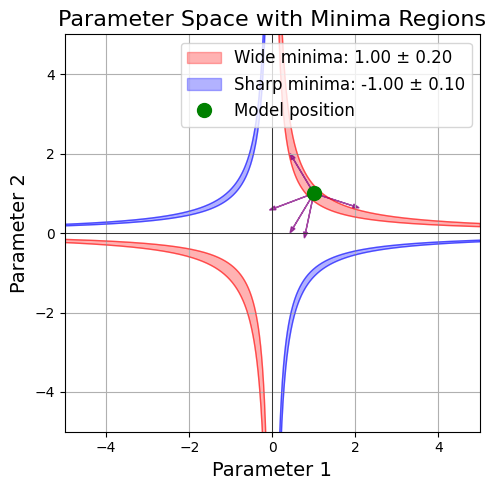

In [8]:
plot_parameter_space_with_arrows(
    loss_fn=loss_fn,
    model=model,
    perturbation_directions=perturbation_directions,
    r_values=np.ones(len(perturbation_directions)),
    x_min=-5, x_max=5,
    y_min=-5, y_max=5,
    fig_size = (5, 5)
)

Now, we apply our radius finding code, and obtain the meaningful radii for each direction. Note that we need to find what the locc value is at our boundary, which is easy.

In [9]:
# At 1 std from the center, our gaussian is
# gaussian_sharp = amplitude * exp(-0.5 * ((±sharp_width)/sharp_width)**2)
#                ≈ amplitude * 0.6065

# The loss is 1 - gaussian_sharp, which is 0.3935
loss_threshold = 0.3935

# we have perturbation directions
# model
# loss_fun
N = 100
x = np.linspace(0, 1.5, N)
coefficients = x**3

results = wiggle_multiple_directions(model = model, loss_fn = loss_fn, 
                                     perturbation_directions = perturbation_directions, 
                                    coefficients = coefficients, verbose =True)

r_values, valid_directions = loss_threshold_crossing(results, loss_threshold)

Evaluating direction 1/5...
Evaluating direction 2/5...
Evaluating direction 3/5...
Evaluating direction 4/5...
Evaluating direction 5/5...


In [10]:
for i, perturb in enumerate(perturbation_directions):
    print ("Direction x ", perturb['params.0'].item(), " y ", perturb['params.1'].item(), " goes to radius ", r_values[i])

Direction x  -0.4967324733734131  y  0.8679037094116211  goes to radius  1.193060077357598
Direction x  -0.1985512226819992  y  -0.9800904989242554  goes to radius  0.16228399699474075
Direction x  0.9478548765182495  y  -0.3187022805213928  goes to radius  0.38467317806160783
Direction x  -0.49822136759757996  y  -0.8670497536659241  goes to radius  0.14913250966969974
Direction x  -0.9299881458282471  y  -0.3675895035266876  goes to radius  0.14913250966969974


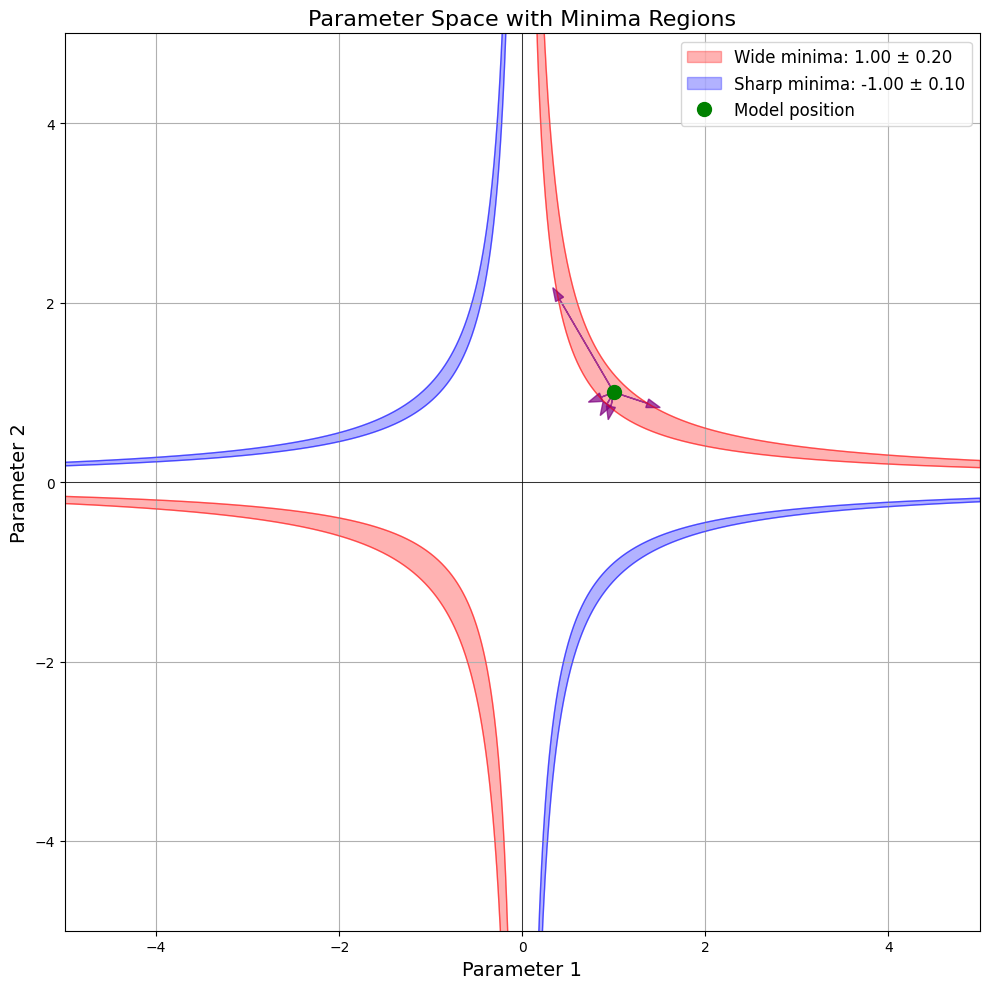

In [11]:
plot_parameter_space_with_arrows(
    loss_fn=loss_fn,
    model=model,
    perturbation_directions=perturbation_directions,
    r_values=r_values,
    x_min=-5, x_max=5,
    y_min=-5, y_max=5,
    fig_size = (10, 10)
)

This seems correct. So our model does find the correct radius at which the threshold is crossed.

## High Accuracy Volume

The random perturbation method has too much variability at such low values. Instead, we produce a uniform number of directions in 2D with the following code.

In [12]:
def generate_circular_perturbations(num_vectors):
    """
    Generate evenly spaced unit vectors around a circle using only PyTorch.
    """
    angles = torch.linspace(0, 2 * torch.pi, num_vectors + 1)[:-1]  # Evenly spaced, exclude duplicate 2π
    x = torch.cos(angles)
    y = torch.sin(angles)
    
    return [
        {'params.0': x[i].reshape(1), 'params.1': y[i].reshape(1)} 
        for i in range(num_vectors)
    ]

In [13]:
circular_perturbations = generate_circular_perturbations(num_vectors=10)

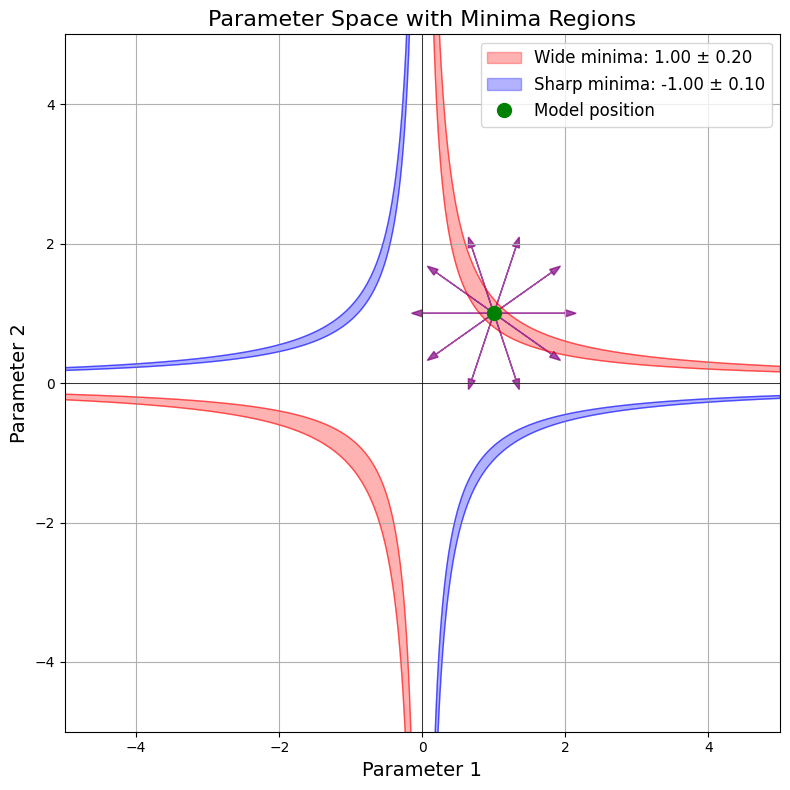

In [14]:
plot_parameter_space_with_arrows(
    loss_fn=loss_fn,
    model=model,
    perturbation_directions=circular_perturbations,
    r_values=np.ones(len(circular_perturbations)),
    x_min=-5, x_max=5,
    y_min=-5, y_max=5,
    fig_size = (8, 8)
)

Now that we can generate circular perturbations, we generate a large number of them, evaluate the r, and visualize the area.

In [15]:
circle_results = wiggle_multiple_directions(model = model, loss_fn = loss_fn, 
                                     perturbation_directions = circular_perturbations, 
                                    coefficients = coefficients, verbose =True)

circle_r_values, circle_valid_directions = loss_threshold_crossing(circle_results, loss_threshold)

Evaluating direction 1/10...
Evaluating direction 2/10...
Evaluating direction 3/10...
Evaluating direction 4/10...
Evaluating direction 5/10...
Evaluating direction 6/10...
Evaluating direction 7/10...
Evaluating direction 8/10...
Evaluating direction 9/10...
Evaluating direction 10/10...


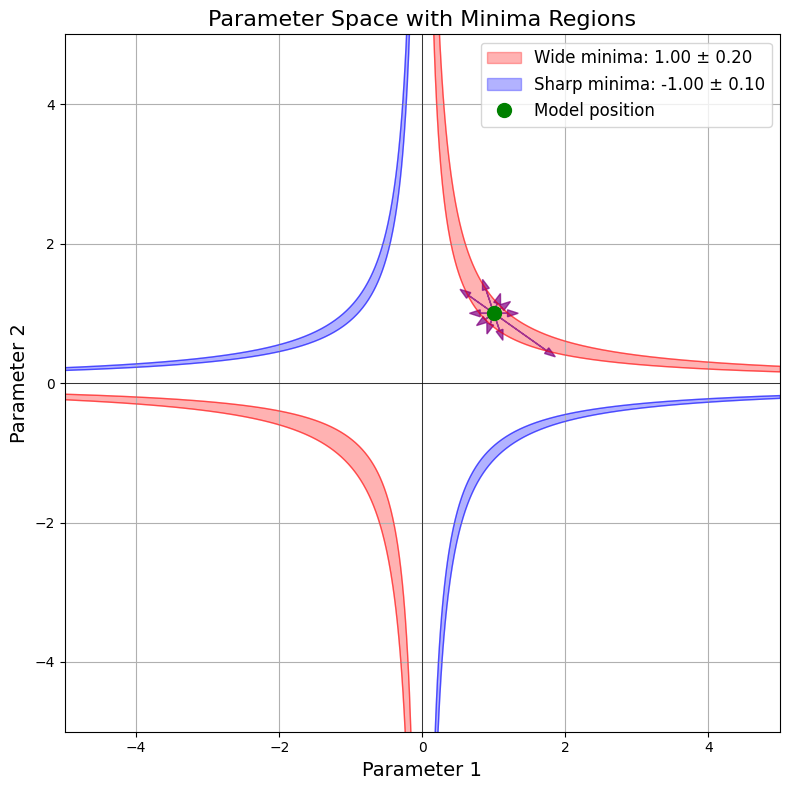

In [16]:
plot_parameter_space_with_arrows(
    loss_fn=loss_fn,
    model=model,
    perturbation_directions=circular_perturbations,
    r_values=circle_r_values,
    x_min=-5, x_max=5,
    y_min=-5, y_max=5,
    fig_size = (8, 8)
)

This matches quite nicely! Just to be sure, we run for a slightly different model.

In [17]:
model2 = NParameterModel([2, 0.5])
circle_results2 = wiggle_multiple_directions(model = model2, loss_fn = loss_fn, 
                                     perturbation_directions = circular_perturbations, 
                                    coefficients = coefficients, verbose =True)
circle_r_values2, circle_valid_directions2 = loss_threshold_crossing(circle_results2, loss_threshold)

Evaluating direction 1/10...
Evaluating direction 2/10...
Evaluating direction 3/10...
Evaluating direction 4/10...
Evaluating direction 5/10...
Evaluating direction 6/10...
Evaluating direction 7/10...
Evaluating direction 8/10...
Evaluating direction 9/10...
Evaluating direction 10/10...


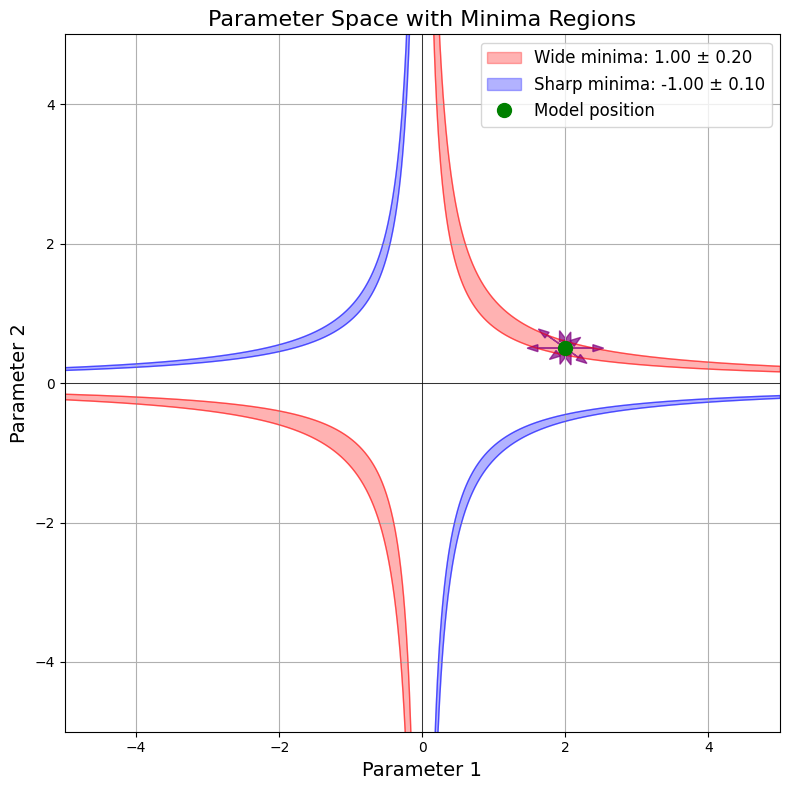

In [18]:
plot_parameter_space_with_arrows(
    loss_fn=loss_fn,
    model=model2,
    perturbation_directions=circular_perturbations,
    r_values=circle_r_values2,
    x_min=-5, x_max=5,
    y_min=-5, y_max=5,
    fig_size = (8, 8)
)

Excellent. To calculate the volume from these radii is simple.

In [19]:
n = 2
circle_2_rn_values = [r**n for r in circle_r_values2]
circle_2_expected_rn = sum(circle_2_rn_values) / len(circle_r_values2)

print (circle_2_expected_rn)

0.05159511655854898


Finally, we can also plot our arrows as a polygon instead.

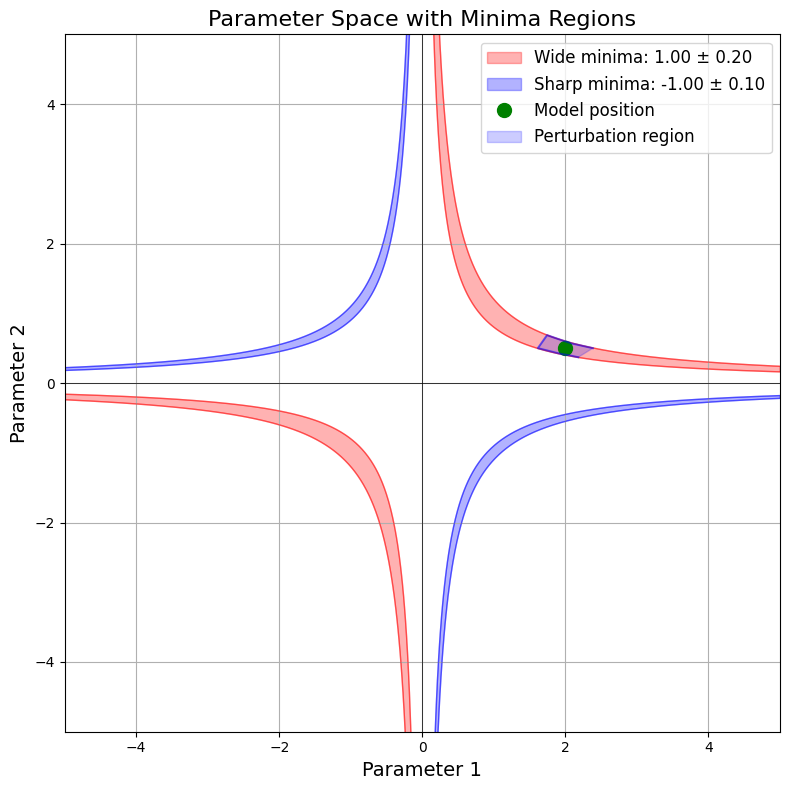

In [20]:
def plot_parameter_space_with_polygon(loss_fn, model, perturbation_directions, r_values,
                                     x_min=-5, x_max=5, y_min=-5, y_max=5,
                                     fig_size=(8, 8), filename=None):
    """
    Plots the 2D parameter space with minima regions, model position, and perturbation polygon.
    
    Args:
        loss_fn: Loss function object that contains minima parameters
        model: The model to plot (must have get_parameter_values() method)
        perturbation_directions: List of perturbation direction dictionaries
        r_values: List of radii for each perturbation direction
        x_min, x_max: X-axis plot limits
        y_min, y_max: Y-axis plot limits
        fig_size: Figure size
        filename: If provided, saves plot to this filename
    """
    _setup_base_plot(loss_fn, x_min, x_max, y_min, y_max, fig_size)
    
    # Plot model position
    origin = model.get_parameter_values()
    plt.plot(origin[0], origin[1], 'go', markersize=10, label="Model position")

    # Calculate endpoints for polygon
    endpoints = []
    for i, perturb in enumerate(perturbation_directions):
        if i < len(r_values):  # Ensure we have a radius for this direction
            direction = np.array([
                perturb['params.0'].item(),
                perturb['params.1'].item()
            ])
            endpoint = origin + direction * r_values[i]
            endpoints.append(endpoint)
    
    if endpoints:
        endpoints = np.array(endpoints)
        # Plot the polygon
        plt.fill(endpoints[:, 0], endpoints[:, 1], color='blue', alpha=0.2, label="Perturbation region")
        plt.plot(endpoints[:, 0], endpoints[:, 1], 'b-', alpha=0.5)

    _finalize_plot(filename)

plot_parameter_space_with_polygon(
    loss_fn=loss_fn,
    model=model2,
    perturbation_directions=circular_perturbations,
    r_values=circle_r_values2,
    x_min=-5, x_max=5,
    y_min=-5, y_max=5,
    fig_size = (8, 8)
)

# Full Code

Having established our pieces work, we generate the following code. We initialize a family of models, distinguished by the scale factor that separates the two layers. We initialize 3 sets of perturbations, representing increasingly refined amounts of directions to sample the volume in. 

For each model in our family, we compute the r values, and the resulting volume. We then plot the value as a function of the scale factor.

In [21]:
scale_factors = np.arange(1, 20, 0.1)
resolutions = [5, 10, 20, 50, 200]  # Number of directions
loss_threshold = 0.3935
dimension = 2

# Generate model family
model_family = [NParameterModel([scale, 1/scale]) for scale in scale_factors]

# Generate perturbations
perturb_vector_list = [generate_circular_perturbations(num_vectors=res) for res in resolutions]

for i, perturb_vec in enumerate(perturb_vector_list):
    print (len(perturb_vec))

# Verify
print(f"Generated {len(model_family)} models:")
for i, model in enumerate(model_family[:5]):  # Show first 3 as example
    params = model.get_parameter_values()  # Assumes this method exists
    print(f"Model {i+1}: params={params}, product={params[0]*params[1]:.2f}")

5
10
20
50
200
Generated 190 models:
Model 1: params=[1.0, 1.0], product=1.00
Model 2: params=[1.100000023841858, 0.9090909361839294], product=1.00
Model 3: params=[1.2000000476837158, 0.8333333134651184], product=1.00
Model 4: params=[1.2999999523162842, 0.7692307829856873], product=1.00
Model 5: params=[1.399999976158142, 0.7142857313156128], product=1.00


Now that we generated the list models, it's time to loop through them and compute the volumes.

In [22]:
"""
# Initialize storage
all_r_values = [[None] * len(perturb_vector_list) for _ in range(len(model_family))]
all_volumes = [[None] * len(perturb_vector_list) for _ in range(len(model_family))]

for model_idx, model in enumerate(model_family):
    print(f"\nProcessing model {model_idx + 1}/{len(model_family)}")
    
    for perturb_idx, perturb_vectors in enumerate(perturb_vector_list):
        res = resolutions[perturb_idx]
        print(f"  Using perturbation set {perturb_idx + 1} (resolution: {res} directions)")
        
        # Calculate loss results
        loss_results = wiggle_multiple_directions(
            model=model,
            loss_fn=loss_fn,
            perturbation_directions=perturb_vectors,
            coefficients=coefficients,
        )
        
        # Get threshold crossings
        r_values, valid_directions = loss_threshold_crossing(loss_results, loss_threshold)
        
        # Check for invalid directions
        if not all(valid_directions):
            invalid_count = len([v for v in valid_directions if not v])
            print(f"    Warning: {invalid_count}/{len(valid_directions)} directions failed threshold")
        
        # Store r_values
        all_r_values[model_idx][perturb_idx] = r_values
        
        # Calculate and store volume (expected r^n)
        if r_values:  # Only if we have valid values
            rn_values = [r**dimension for r in r_values]
            volume = sum(rn_values) / len(rn_values)
            all_volumes[model_idx][perturb_idx] = volume
            print(f"    Computed volume: {volume:.4f}")
        else:
            print("    No valid directions - skipping volume calculation")
"""

'\n# Initialize storage\nall_r_values = [[None] * len(perturb_vector_list) for _ in range(len(model_family))]\nall_volumes = [[None] * len(perturb_vector_list) for _ in range(len(model_family))]\n\nfor model_idx, model in enumerate(model_family):\n    print(f"\nProcessing model {model_idx + 1}/{len(model_family)}")\n    \n    for perturb_idx, perturb_vectors in enumerate(perturb_vector_list):\n        res = resolutions[perturb_idx]\n        print(f"  Using perturbation set {perturb_idx + 1} (resolution: {res} directions)")\n        \n        # Calculate loss results\n        loss_results = wiggle_multiple_directions(\n            model=model,\n            loss_fn=loss_fn,\n            perturbation_directions=perturb_vectors,\n            coefficients=coefficients,\n        )\n        \n        # Get threshold crossings\n        r_values, valid_directions = loss_threshold_crossing(loss_results, loss_threshold)\n        \n        # Check for invalid directions\n        if not all(valid_d

In [23]:
"""
plt.figure(figsize=(10, 6))

# Extract x-axis values (first parameter of each model)
x_values = [model.get_parameter_values()[0] for model in model_family]

# Plot each resolution as separate line
for perturb_idx, res in enumerate(resolutions):
    # Get volumes for this resolution across all models
    volumes = [all_volumes[model_idx][perturb_idx] 
              for model_idx in range(len(model_family))]
    
    plt.plot(x_values, volumes, 'o-', 
            label=f'{res} directions',
            markersize=5, linewidth=2)

plt.xlabel('First Parameter Value (scale)', fontsize=12)
plt.ylabel('Volume (r^n)', fontsize=12)
plt.title('Volume vs Parameter Scale at Different Resolutions', fontsize=14)
plt.legend(title='Resolution', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()"""

"\nplt.figure(figsize=(10, 6))\n\n# Extract x-axis values (first parameter of each model)\nx_values = [model.get_parameter_values()[0] for model in model_family]\n\n# Plot each resolution as separate line\nfor perturb_idx, res in enumerate(resolutions):\n    # Get volumes for this resolution across all models\n    volumes = [all_volumes[model_idx][perturb_idx] \n              for model_idx in range(len(model_family))]\n    \n    plt.plot(x_values, volumes, 'o-', \n            label=f'{res} directions',\n            markersize=5, linewidth=2)\n\nplt.xlabel('First Parameter Value (scale)', fontsize=12)\nplt.ylabel('Volume (r^n)', fontsize=12)\nplt.title('Volume vs Parameter Scale at Different Resolutions', fontsize=14)\nplt.legend(title='Resolution', fontsize=10)\nplt.grid(True, alpha=0.3)\nplt.tight_layout()\nplt.show()"

Very weird. Here's code that plots the shape for a single perturbation - let's try and understand why the volume is diverging.

In [39]:
def plot_single_perturbation_shape(model, model_idx, perturb_idx, perturb_vector_list, all_r_values, 
                                 x_lim=(0, 5), y_lim=(0, 5), figsize=(4, 4)):
    """
    Plot the perturbation shape for a specific model and perturbation resolution.
    
    Args:
        model: The model to visualize
        model_idx: Index of the model in model_family
        perturb_idx: Index of perturbation resolution to use
        perturb_vector_list: List of all perturbation sets
        all_r_values: 3D list of r values [model_idx][perturb_idx][direction_idx]
        x_lim: x-axis limits
        y_lim: y-axis limits
        figsize: Figure size
    """
    params = loss_fn.get_minima_parameters()

    # Parameters for the red curve (a1, w1)
    a1 = params['minima_wide_loc']
    w1 = params['wide_width']

    # Parameters for the blue curve (a2, w2)
    a2 = params['minima_sharp_loc']
    w2 = params['sharp_width']

    plt.figure(figsize=figsize)

    # Create x values (avoid x=0)
    x_pos = np.linspace(1e-5, 10, 500)  # Positive x
    x_neg = np.linspace(10, -1e-5, 500)  # Negative x

    # Calculate bounds for red curve (a1, w1)
    red_upper_pos = (a1 + w1)/x_pos
    red_lower_pos = (a1 - w1)/x_pos
    red_upper_neg = (a1 + w1)/x_neg
    red_lower_neg = (a1 - w1)/x_neg

    # Calculate bounds for blue curve (a2, w2)
    blue_upper_pos = (a2 + w2)/x_pos
    blue_lower_pos = (a2 - w2)/x_pos
    blue_upper_neg = (a2 + w2)/x_neg
    blue_lower_neg = (a2 - w2)/x_neg
    
    # Fill the red region (a1 ± 2w1)
    plt.fill_between(x_pos, red_lower_pos, red_upper_pos, color='red', alpha=0.3, label=f'a₁ = {a1} ± {2*w1}')
    plt.fill_between(x_neg, red_lower_neg, red_upper_neg, color='red', alpha=0.3)
    
    # Fill the blue region (a2 ± 2w2)
    plt.fill_between(x_pos, blue_lower_pos, blue_upper_pos, color='blue', alpha=0.3, label=f'a₂ = {a2} ± {2*w2}')
    plt.fill_between(x_neg, blue_lower_neg, blue_upper_neg, color='blue', alpha=0.3)
    
    # Plot the boundary lines for both regions
    plt.plot(x_pos, red_upper_pos, 'r-', linewidth=1, alpha=0.5)
    plt.plot(x_pos, red_lower_pos, 'r-', linewidth=1, alpha=0.5)
    plt.plot(x_neg, red_upper_neg, 'r-', linewidth=1, alpha=0.5)
    plt.plot(x_neg, red_lower_neg, 'r-', linewidth=1, alpha=0.5)
    
    plt.plot(x_pos, blue_upper_pos, 'b-', linewidth=1, alpha=0.5)
    plt.plot(x_pos, blue_lower_pos, 'b-', linewidth=1, alpha=0.5)
    plt.plot(x_neg, blue_upper_neg, 'b-', linewidth=1, alpha=0.5)
    plt.plot(x_neg, blue_lower_neg, 'b-', linewidth=1, alpha=0.5)
    
    # Get model parameters
    model_params = model.get_parameter_values()
    origin = np.array([model_params[0], model_params[1]])
    
    # Get perturbation vectors and r values
    perturb_vectors = perturb_vector_list[perturb_idx]
    r_values = all_r_values[model_idx][perturb_idx]
    
    # Calculate endpoints
    endpoints = []
    for arrow_id, perturb in enumerate(perturb_vectors):
        direction = np.array([perturb['params.0'].item(), perturb['params.1'].item()])
        endpoint = origin + direction * r_values[arrow_id]
        endpoints.append(endpoint)
    
    endpoints = np.array(endpoints)
    
    # Plot the shape
    plt.fill(endpoints[:, 0], endpoints[:, 1], color='blue', alpha=0.2)
    plt.plot(endpoints[:, 0], endpoints[:, 1], 'b-', alpha=0.5)
    
    # Plot model point
    plt.plot(origin[0], origin[1], 'go', markersize=8, label=f"Model {model_idx}")
    
    # Plot settings
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    plt.gca().set_aspect('equal')
    plt.xlabel("Parameter 0")
    plt.ylabel("Parameter 1")
    plt.title(f"Resolution: {len(perturb_vectors)} directions")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_all_perturbation_shapes(model, model_idx, perturb_vector_list, all_r_values, all_volumes,
                                x_lim=(0, 5), y_lim=(0, 5)):
    """
    Generate all perturbation shape plots for a given model.
    
    Args:
        model: The model to visualize
        model_idx: Index of the model in model_family
        perturb_vector_list: List of all perturbation sets
        all_r_values: 3D list of r values [model_idx][perturb_idx][direction_idx]
        x_lim: x-axis limits
        y_lim: y-axis limits
    """
    for perturb_idx in range(len(perturb_vector_list)):
        plot_single_perturbation_shape(
            model=model,
            model_idx=model_idx,
            perturb_idx=perturb_idx,
            perturb_vector_list=perturb_vector_list,
            all_r_values=all_r_values,
            x_lim=x_lim,
            y_lim=y_lim,
            figsize=(5, 5)
        )
        print ("The volume is ", all_volumes[model_idx][perturb_idx])

# Usage example:
model_idx = 20  # Example model (scale 3.0)
model = model_family[model_idx]

# Plot all perturbation resolutions for this model
plot_all_perturbation_shapes(
    model=model,
    model_idx=model_idx,
    perturb_vector_list=perturb_vector_list,
    all_r_values=all_r_values,
    all_volumes=all_volumes
)

NameError: name 'all_r_values' is not defined

In [34]:
"""
# Usage example:
model_idx = 15  # Example model (scale 3.0)
model = model_family[model_idx]

# Plot all perturbation resolutions for this model
plot_all_perturbation_shapes(
    model=model,
    model_idx=model_idx,
    perturb_vector_list=perturb_vector_list,
    all_r_values=all_r_values,
    all_volumes=all_volumes
)"""

'\n# Usage example:\nmodel_idx = 15  # Example model (scale 3.0)\nmodel = model_family[model_idx]\n\n# Plot all perturbation resolutions for this model\nplot_all_perturbation_shapes(\n    model=model,\n    model_idx=model_idx,\n    perturb_vector_list=perturb_vector_list,\n    all_r_values=all_r_values,\n    all_volumes=all_volumes\n)'

From our code, we observe large issues in volume estimation with a small number of random directions. This is most extremely demonstrated in the above volume estimations for 20 random directions, where the volume abruptly changes by a large fraction as the scale increases. Therefore going forward, we'll focus primarily on a large number of directions (for stability). We'll also increase the range of coefficients (the current resolution seems fine, but there are cases where it does not reach a loss threshold in time). And finally, plot for a smaller range of scale factors (extremely large values are not realistic).

In [25]:
scale_factors2 = np.arange(1, 4, 1.0)
resolutions2 = [200, 400]  # Number of directions
loss_threshold = 0.3935
dimension = 2

N = 100
x = np.linspace(0, 2.0, N)
coefficients = x**3

# Generate model family
model_family2 = [NParameterModel([scale, 1/scale]) for scale in scale_factors2]

# Generate perturbations
perturb_vector_list2 = [generate_circular_perturbations(num_vectors=res) for res in resolutions2]

In [26]:
# Initialize storage
all_r_values2 = [[None] * len(perturb_vector_list2) for _ in range(len(model_family2))]
all_volumes2 = [[None] * len(perturb_vector_list2) for _ in range(len(model_family2))]

for model_idx, model in enumerate(model_family2):
    print(f"\nProcessing model {model_idx + 1}/{len(model_family2)}")
    
    for perturb_idx, perturb_vectors in enumerate(perturb_vector_list2):
        res = resolutions2[perturb_idx]
        print(f"  Using perturbation set {perturb_idx + 1} (resolution: {res} directions)")
        
        # Calculate loss results
        loss_results = wiggle_multiple_directions(
            model=model,
            loss_fn=loss_fn,
            perturbation_directions=perturb_vectors,
            coefficients=coefficients,
        )
        
        # Get threshold crossings
        r_values, valid_directions = loss_threshold_crossing(loss_results, loss_threshold)
        
        # Check for invalid directions
        if not all(valid_directions):
            invalid_count = len([v for v in valid_directions if not v])
            print(f"    Warning: {invalid_count}/{len(valid_directions)} directions failed threshold")
        
        # Store r_values
        all_r_values2[model_idx][perturb_idx] = r_values
        
        # Calculate and store volume (expected r^n)
        if r_values:  # Only if we have valid values
            rn_values = [r**dimension for r in r_values]
            volume = sum(rn_values) / len(rn_values)
            all_volumes2[model_idx][perturb_idx] = volume
            print(f"    Computed volume: {volume:.4f}")
        else:
            print("    No valid directions - skipping volume calculation")


Processing model 1/3
  Using perturbation set 1 (resolution: 200 directions)
    Computed volume: 0.2054
  Using perturbation set 2 (resolution: 400 directions)
    Computed volume: 0.1994

Processing model 2/3
  Using perturbation set 1 (resolution: 200 directions)
    Computed volume: 0.2008
  Using perturbation set 2 (resolution: 400 directions)
    Computed volume: 0.2095

Processing model 3/3
  Using perturbation set 1 (resolution: 200 directions)
    Computed volume: 0.1983
  Using perturbation set 2 (resolution: 400 directions)
    Computed volume: 0.2345


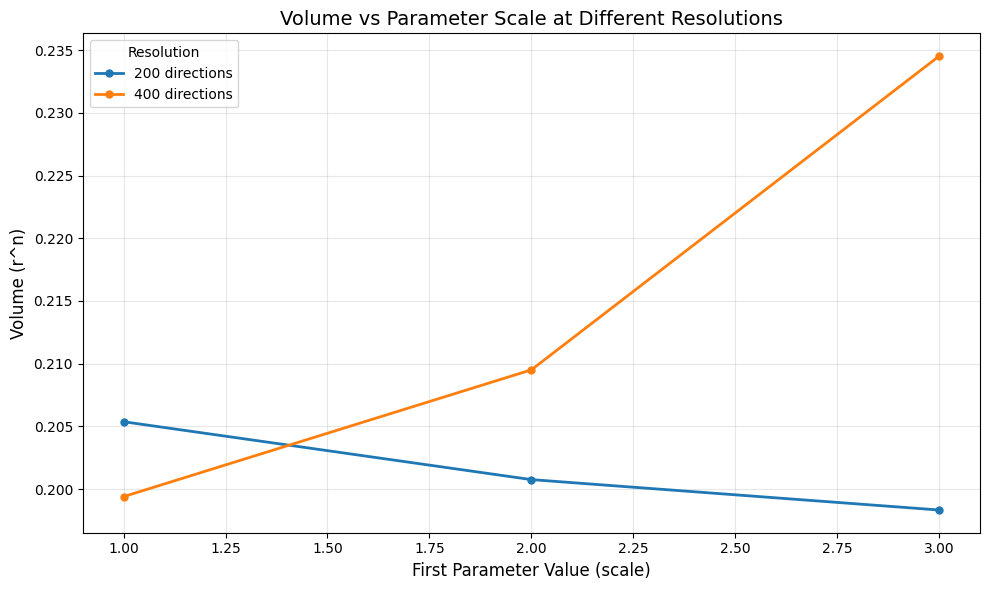

In [35]:
plt.figure(figsize=(10, 6))

# Extract x-axis values (first parameter of each model)
x_values = [model.get_parameter_values()[0] for model in model_family2]

# Plot each resolution as separate line
for perturb_idx, res in enumerate(resolutions2):
    # Get volumes for this resolution across all models
    volumes = [all_volumes2[model_idx][perturb_idx] 
              for model_idx in range(len(model_family2))]
    
    plt.plot(x_values, volumes, 'o-', 
            label=f'{res} directions',
            markersize=5, linewidth=2)

plt.xlabel('First Parameter Value (scale)', fontsize=12)
plt.ylabel('Volume (r^n)', fontsize=12)
plt.title('Volume vs Parameter Scale at Different Resolutions', fontsize=14)
plt.legend(title='Resolution', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

[1.0, 1.0]


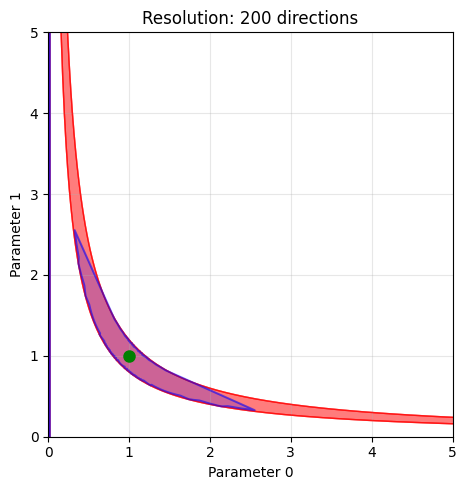

The volume is  0.20537234868305837


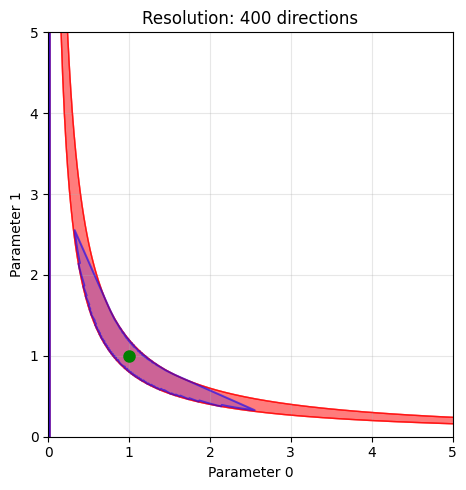

The volume is  0.19939641801373964


In [40]:
# Usage example:
model_idx = 0  # Example model (scale 3.0)
model = model_family2[model_idx]
print (model.get_parameter_values())

# Plot all perturbation resolutions for this model
plot_all_perturbation_shapes(
    model=model,
    model_idx=model_idx,
    perturb_vector_list=perturb_vector_list2,
    all_r_values=all_r_values2,
    all_volumes=all_volumes2
)

In [44]:
def plot_single_perturbation_shape_save(model, model_idx, perturb_idx, perturb_vector_list, all_r_values, 
                                 x_lim=(0, 5), y_lim=(0, 3), figsize=(4, 4), filename="figure.png"):
    """
    Plot the perturbation shape for a specific model and perturbation resolution.
    
    Args:
        model: The model to visualize
        model_idx: Index of the model in model_family
        perturb_idx: Index of perturbation resolution to use
        perturb_vector_list: List of all perturbation sets
        all_r_values: 3D list of r values [model_idx][perturb_idx][direction_idx]
        x_lim: x-axis limits
        y_lim: y-axis limits
        figsize: Figure size
    """
    plt.figure(figsize=figsize)

    # Fill the red region (a1 ± 2w1)
    plt.fill_between(x_pos, red_lower_pos, red_upper_pos, color='red', alpha=0.3)#, label=f'a₁ = {a1} ± {2*w1}')
    plt.fill_between(x_neg, red_lower_neg, red_upper_neg, color='red', alpha=0.3)
    
    # Fill the blue region (a2 ± 2w2)
    plt.fill_between(x_pos, blue_lower_pos, blue_upper_pos, color='blue', alpha=0.3)#, label=f'a₂ = {a2} ± {2*w2}')
    plt.fill_between(x_neg, blue_lower_neg, blue_upper_neg, color='blue', alpha=0.3)
    
    # Plot the boundary lines for both regions
    plt.plot(x_pos, red_upper_pos, 'r-', linewidth=1, alpha=0.5)
    plt.plot(x_pos, red_lower_pos, 'r-', linewidth=1, alpha=0.5)
    plt.plot(x_neg, red_upper_neg, 'r-', linewidth=1, alpha=0.5)
    plt.plot(x_neg, red_lower_neg, 'r-', linewidth=1, alpha=0.5)
    
    plt.plot(x_pos, blue_upper_pos, 'b-', linewidth=1, alpha=0.5)
    plt.plot(x_pos, blue_lower_pos, 'b-', linewidth=1, alpha=0.5)
    plt.plot(x_neg, blue_upper_neg, 'b-', linewidth=1, alpha=0.5)
    plt.plot(x_neg, blue_lower_neg, 'b-', linewidth=1, alpha=0.5)
    
    # Get model parameters
    model_params = model.get_parameter_values()
    origin = np.array([model_params[0], model_params[1]])
    
    # Get perturbation vectors and r values
    perturb_vectors = perturb_vector_list[perturb_idx]
    r_values = all_r_values[model_idx][perturb_idx]
    
    # Calculate endpoints
    endpoints = []
    for arrow_id, perturb in enumerate(perturb_vectors):
        direction = np.array([perturb['params.0'].item(), perturb['params.1'].item()])
        endpoint = origin + direction * r_values[arrow_id]
        endpoints.append(endpoint)
    
    endpoints = np.array(endpoints)
    
    # Plot the shape
    plt.fill(endpoints[:, 0], endpoints[:, 1], color='blue', alpha=0.2)
    plt.plot(endpoints[:, 0], endpoints[:, 1], 'b-', alpha=0.5)
    
    # Plot model point
    plt.plot(origin[0], origin[1], 'go', markersize=8, label=f"Local Volume Center")
    
    # Plot settings
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    plt.xlabel("Layer 1 Norm")
    plt.ylabel("Layer 2 Norm")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.legend()
    plt.savefig(filename)
    plt.show()
    

[1.0, 1.0]


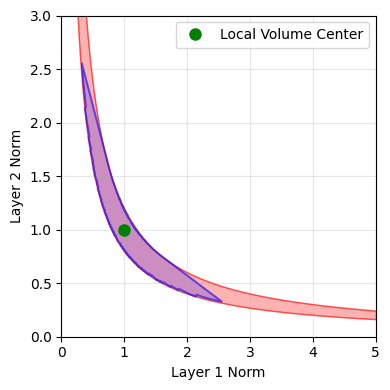

[2.0, 0.5]


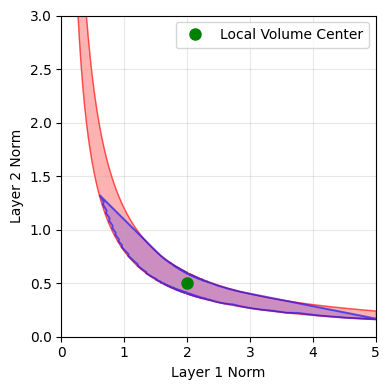

In [47]:
params = loss_fn.get_minima_parameters()

# Parameters for the red curve (a1, w1)
a1 = params['minima_wide_loc']
w1 = params['wide_width']

# Parameters for the blue curve (a2, w2)
a2 = params['minima_sharp_loc']
w2 = params['sharp_width']

# Create x values (avoid x=0)
x_pos = np.linspace(1e-10, 5, 500)  # Positive x
x_neg = np.linspace(-5, -1e-10, 500)  # Negative x

# Calculate bounds for red curve (a1, w1)
red_upper_pos = (a1 + w1)/x_pos
red_lower_pos = (a1 - w1)/x_pos
red_upper_neg = (a1 + w1)/x_neg
red_lower_neg = (a1 - w1)/x_neg

# Calculate bounds for blue curve (a2, w2)
blue_upper_pos = (a2 + w2)/x_pos
blue_lower_pos = (a2 - w2)/x_pos
blue_upper_neg = (a2 + w2)/x_neg
blue_lower_neg = (a2 - w2)/x_neg

# Usage example:
model_idx = 0  # Example model (scale 3.0)
model = model_family2[model_idx]
print (model.get_parameter_values())

# Plot a perturbation resolution for this model
plot_single_perturbation_shape_save(model=model, model_idx=model_idx, 
                                    perturb_idx = 1, perturb_vector_list = perturb_vector_list2, 
                                    all_r_values = all_r_values2, filename="scale1.png")


# Usage example:
model_idx = 1  # Example model (scale 3.0)
model = model_family2[model_idx]
print (model.get_parameter_values())

# Plot a perturbation resolution for this model
plot_single_perturbation_shape_save(model=model, model_idx=model_idx, 
                                    perturb_idx = 1, perturb_vector_list = perturb_vector_list2, 
                                    all_r_values = all_r_values2, filename="scale2.png")



In [ ]:
def compute_volumes(model_family, perturbation_sets, resolutions, 
                   loss_fn, coefficients, loss_threshold, dimension,
                   verbose=True):
    """
    Compute volumes for a model family across different perturbation resolutions.
    
    Args:
        model_family: List of models to analyze
        perturbation_sets: List of perturbation direction sets
        resolutions: List of resolution values corresponding to perturbation_sets
        loss_fn: Loss function to evaluate
        coefficients: List of perturbation coefficients
        loss_threshold: Threshold for valid directions
        dimension: Exponent n for volume calculation
        verbose: Whether to print progress
        
    Returns:
        Tuple of (all_r_values, all_volumes) where:
        - all_r_values: 2D list [model_idx][perturb_idx] of r value lists
        - all_volumes: 2D list [model_idx][perturb_idx] of volume values
    """
    # Initialize storage
    all_r_values = [[None] * len(perturbation_sets) for _ in range(len(model_family))]
    all_volumes = [[None] * len(perturbation_sets) for _ in range(len(model_family))]
    
    for model_idx, model in enumerate(model_family):
        if verbose:
            print(f"\nProcessing model {model_idx + 1}/{len(model_family)}")
        
        for perturb_idx, perturb_vectors in enumerate(perturbation_sets):
            res = resolutions[perturb_idx]
            if verbose:
                print(f"  Using perturbation set {perturb_idx + 1} (resolution: {res} directions)")
            
            # Calculate loss results
            loss_results = wiggle_multiple_directions(
                model=model,
                loss_fn=loss_fn,
                perturbation_directions=perturb_vectors,
                coefficients=coefficients,
                verbose=verbose
            )
            
            # Get threshold crossings
            r_values, valid_directions = loss_threshold_crossing(loss_results, loss_threshold)
            
            # Check for invalid directions
            if verbose and not all(valid_directions):
                invalid_count = len([v for v in valid_directions if not v])
                print(f"    Warning: {invalid_count}/{len(valid_directions)} directions failed threshold")
            
            # Store r_values
            all_r_values[model_idx][perturb_idx] = r_values
            
            # Calculate and store volume
            if r_values:
                rn_values = [r**dimension for r in r_values]
                volume = sum(rn_values) / len(rn_values)
                all_volumes[model_idx][perturb_idx] = volume
                if verbose:
                    print(f"    Computed volume: {volume:.4f}")
            elif verbose:
                print("    No valid directions - skipping volume calculation")
    
    return all_r_values, all_volumes

In [ ]:

all_r_values2, all_volumes2 = compute_volumes(
    model_family=model_family2,
    perturbation_sets=perturb_vector_list2,
    resolutions=resolutions2,
    loss_fn=loss_fn,
    coefficients=coefficients,
    loss_threshold=0.3935,
    dimension=2
)

In [ ]:

all_r_values2, all_volumes2 = compute_volumes(
    model_family=model_family2,
    perturbation_sets=perturb_vector_list2,
    resolutions=resolutions2,
    loss_fn=loss_fn,
    coefficients=coefficients,
    loss_threshold=0.3935,
    dimension=2
)